Курсовая работа

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
import seaborn
from PIL import Image 
from torch.utils.data import Dataset
from torch import optim


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
data_dir = '../content/drive/MyDrive/Colab_data/leapGestRecog'
print(os.listdir(data_dir))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [ ]:
classes = os.listdir('../content/drive/MyDrive/Colab_data/leapGestRecog/00/')
classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [ ]:
class_to_index = {}
index_to_class = {}
for i, class_name in enumerate(classes):
  class_to_index[class_name] = i
  index_to_class[i] = class_name

In [ ]:
index_to_class

{0: '01_palm',
 1: '02_l',
 2: '03_fist',
 3: '04_fist_moved',
 4: '05_thumb',
 5: '06_index',
 6: '07_ok',
 7: '08_palm_moved',
 8: '09_c',
 9: '10_down'}

In [ ]:
# Собираем все адреса картинок для добавления в df
images_addr = []
for root, dirs, files in os.walk('../content/drive/MyDrive/Colab_data/leapGestRecog'):
    for name in files:
        f = os.path.join(root, name)
        images_addr.append(f)

In [ ]:
len(images_addr)


20000

In [ ]:
dataframe = pd.DataFrame(images_addr, columns=['images_addr'])
dataframe.head()

,images_addr
0,../content/drive/MyDrive/Colab_data/leapGestRe...
1,../content/drive/MyDrive/Colab_data/leapGestRe...
2,../content/drive/MyDrive/Colab_data/leapGestRe...
3,../content/drive/MyDrive/Colab_data/leapGestRe...
4,../content/drive/MyDrive/Colab_data/leapGestRe...


In [ ]:
# Сформируем индекс напротив адреса каждой картинки в dataframe

# Вырезаем из адресов имена классов
dataframe['class_index'] = dataframe['images_addr'].apply(lambda x: x.split('/')[7])
dataframe.head()

,images_addr,class_index
0,../content/drive/MyDrive/Colab_data/leapGestRe...,01_palm
1,../content/drive/MyDrive/Colab_data/leapGestRe...,01_palm
2,../content/drive/MyDrive/Colab_data/leapGestRe...,01_palm
3,../content/drive/MyDrive/Colab_data/leapGestRe...,01_palm
4,../content/drive/MyDrive/Colab_data/leapGestRe...,01_palm


In [ ]:
# Произведем замену имени класса на индекс класса
dataframe['class_index'] = dataframe['class_index'].apply(lambda x: class_to_index[x])

In [ ]:
dataframe['class_index'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, dataframe):
        # Подаем наш подготовленный датафрейм
        self.dataframe = dataframe
        
        # Разделяем датафрейм на адреса картинок
        self.images_addr_arr = self.dataframe.iloc[:,0]
        # и номера классов
        self.class_index_arr = self.dataframe.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.dataframe.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        image = np.asarray(Image.open(self.images_addr_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        image = torch.as_tensor(image)/255
        # Добавляем батч измерение
        image = image.unsqueeze(0)
        # Без этого дополнительного измерения интерполяция не работает
        image = image.unsqueeze(0)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        image = F.interpolate(input=image, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        # Возвращаемся к 4-м измерениям
        image = image.squeeze(1)
        
        # Читаем индекс класса 
        class_index = self.class_index_arr[index].astype('int')
        
        return (image.float(), class_index)

    def __len__(self):
        return self.data_len

In [ ]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(dataframe, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=16, shuffle=False)

Создание класса модели

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64*4*4)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
# Проверим правильность работы сети, прогнав через нее картинку
net = Net().to(device)
result = net(image.to(device))
result.shape

torch.Size([16, 10])

In [ ]:
result = torch.argmax(result, dim=1)
result

tensor([4, 1, 4, 4, 1, 1, 4, 1, 4, 1, 4, 1, 1, 4, 4, 1])

In [ ]:
class_index


tensor([8, 4, 6, 0, 3, 1, 1, 9, 1, 8, 0, 7, 9, 5, 0, 1])

In [ ]:
float(torch.sum(result == class_index.to(device)).item())


2.0

Обучение модели

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
epoch_losses = []
batch_size = 16
num_epochs = 3

for epoch in range(num_epochs):  
    train_loss = 0.0
    train_acc  = 0.0

    epoch_loss = []
    epoch_accuracy = []
    time1 = time.time()

    for batch_idx, data in enumerate(train_data_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        accuracy = float(torch.sum(torch.argmax(outputs, dim=1) == labels).item())/batch_size
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy)
        if (batch_idx+1) % 100 == 99:
            print(f'Train Epoch: {epoch+1}, Train loss: {train_loss/100:.4f}, Train accuracy: {train_acc/100:.4f}')
            time2 = time.time()
            print(f'Spend time for 100 batches: {time2 - time1:.4f} sec')
            time1 = time.time()
            train_loss = 0.0
            train_acc  = 0.0

    total_steps = len(test_data_loader)
    val_loss = 0.0
    val_acc  = 0.0
    with torch.no_grad():
        for data in test_data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            val_acc += float(torch.sum(torch.argmax(outputs, dim=1) == labels).item())/batch_size
            loss = criterion(outputs, labels)
            val_loss += loss
    print(f'Epoch {epoch+1}, Train loss: {np.mean(epoch_loss):.4f}, '
                           f'Train acc: {np.mean(epoch_accuracy):.4f}, ' 
                           f'Validate loss: {val_loss/total_steps:.4f}, ' 
                           f'Validate acc: {val_acc/total_steps:.4f}')
    epoch_losses.append(epoch_loss) 

print('Training is finished!')

Train Epoch: 1, Train loss: 1.9024, Train accuracy: 0.2844
Spend time for 100 batches: 628.4233 sec
Train Epoch: 1, Train loss: 0.8638, Train accuracy: 0.7206
Spend time for 100 batches: 568.3084 sec
Train Epoch: 1, Train loss: 0.3636, Train accuracy: 0.8862
Spend time for 100 batches: 540.8238 sec
Train Epoch: 1, Train loss: 0.2036, Train accuracy: 0.9350
Spend time for 100 batches: 532.0331 sec
Train Epoch: 1, Train loss: 0.1480, Train accuracy: 0.9494
Spend time for 100 batches: 537.3890 sec
Train Epoch: 1, Train loss: 0.1092, Train accuracy: 0.9681
Spend time for 100 batches: 529.5414 sec
Train Epoch: 1, Train loss: 0.0709, Train accuracy: 0.9794
Spend time for 100 batches: 533.4662 sec
Train Epoch: 1, Train loss: 0.0851, Train accuracy: 0.9762
Spend time for 100 batches: 528.2799 sec
Epoch 1, Train loss: 0.4320, Train acc: 0.8514, Validate loss: 0.0305, Validate acc: 0.9935
Train Epoch: 2, Train loss: 0.0455, Train accuracy: 0.9762
Spend time for 100 batches: 11.9308 sec
Train Epo

Text(0.5, 1.0, 'losses vs. No. of epochs')

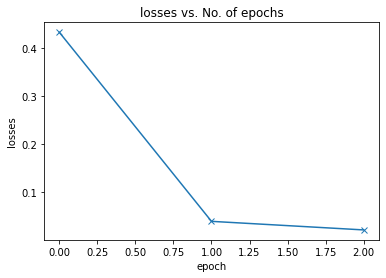

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Вывод полученных результатов

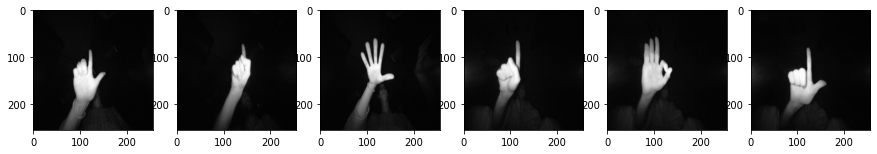

GroundTruth:             02_l        06_index         10_down        06_index           07_ok            02_l
Predicted:               02_l        06_index         10_down        06_index           07_ok            02_l


In [ ]:

N=6

test_loader = DataLoader(test_data, batch_size = N, shuffle=True)

data_iter = iter(test_loader)
images, labels = data_iter.next()
net = net.to(device)
outputs = net(images.to(device))

f, axarr = plt.subplots(1,N, figsize=(15,15))
for i in range(N):
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
  axarr[i].imshow(images[i].numpy()[0], cmap='gray')
plt.show()

print('GroundTruth: ', ' '.join('%15s' % index_to_class[labels[j].item()] for j in range(N)))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%15s' % index_to_class[predicted[j].item()] for j in range(N)))

In [ ]:
torch.save(net, '../content/drive/MyDrive/Colab_data/model.pth')